It's Sunday morning, it's quiet and you wake up with a big smile on your face. Today is going to be a great day! Except, your phone rings, rather "internationally". You pick it up slowly and hear something really bizarre - "Bonjour, je suis Michele. Oops, sorry. I am Michele, your personal bank agent.". What could possibly be so urgent for someone from Switzerland to call you at this hour? "Did you authorize a transaction for $3,358.65 for 100 copies of Diablo 3?" Immediately, you start thinking of ways to explain why you did that to your loved one. "No, I didn't !?". Michele's answer is quick and to the point - "Thank you, we're on it". Whew, that was close! But how did Michele knew that this transaction was suspicious? After all, you did order 10 new smartphones from that same bank account, last week - Michele didn't call then.



Annual global fraud losses reached $21.8 billion in 2015, according to Nilson Report.(visit:https://www.nilsonreport.com/upload/content_promo/The_Nilson_Report_10-17-2016.pdf)

Probably you feel very lucky if you are a fraud. About every 12 cents per $100 were stolen in the US during the same year. Our friend Michele might have a serious problem to solve here.

In this part of the series, we will train an Autoencoder Neural Network (implemented in Keras) in unsupervised (or semi-supervised) fashion for Anomaly Detection in credit card transaction data. The trained model will be evaluated on pre-labeled and anonymized dataset.

# Setup

In [3]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = (15,10)

RANDOM_SEED = 42
LABELS = ["Normal","Fraud"]

# Loading the data

The dataset we're going to use can be downloaded from Kaggle. It contains data about credit card transactions that occurred during a period of two days, with 492 frauds out of 284,807 transactions.

All variables in the dataset are numerical. The data has been transformed using PCA transformation(s) due to privacy reasons. The two features that haven't been changed are Time and Amount. Time contains the seconds elapsed between each transaction and the first transaction in the dataset.

In [4]:
df = pd.read_csv("E:/Data Science/Credit Card Fraud Detection/data/creditcardfraud/creditcard.csv")

# Exploration

In [5]:
df.shape

(284807, 31)

31 columns, 2 of which are Time and Amount. The rest are output from the PCA transformation. Let's check for missing values:

In [6]:
df.isnull().values.any()

False

Text(0, 0.5, 'Frequency')

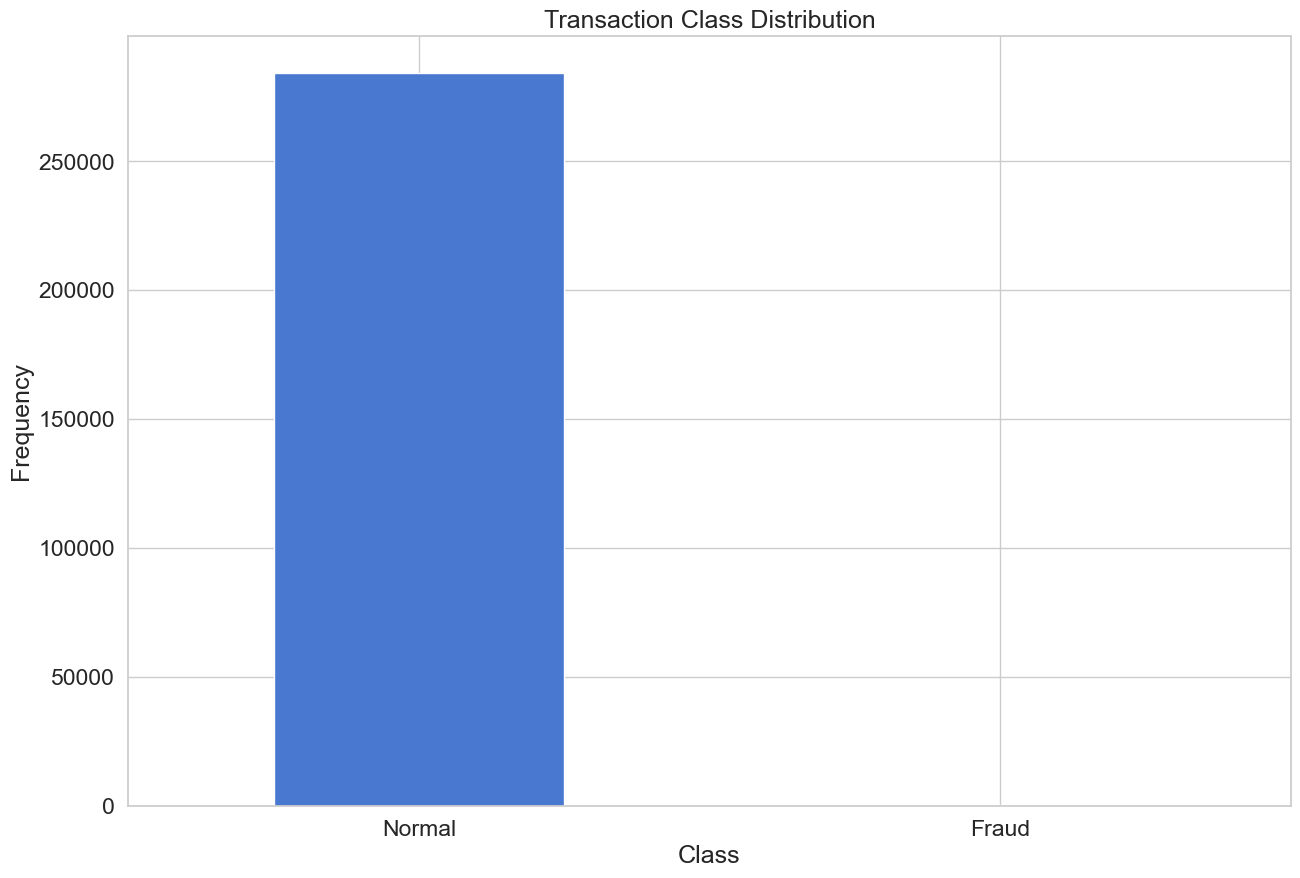

In [7]:
count_classes = pd.value_counts(df['Class'], sort=True)
count_classes.plot(kind='bar', rot=0)
plt.title("Transaction Class Distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency")

We have a highly imbalanced dataset on our hands. Normal transactions overwhelm the fraudulent ones by a large margin. Let's look at the two types of transactions:

In [8]:
frauds = df[df.Class == 1]
normal = df[df.Class == 0]

In [9]:
frauds.shape

(492, 31)

In [10]:
normal.shape

(284315, 31)

In [11]:
frauds.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [12]:
normal.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

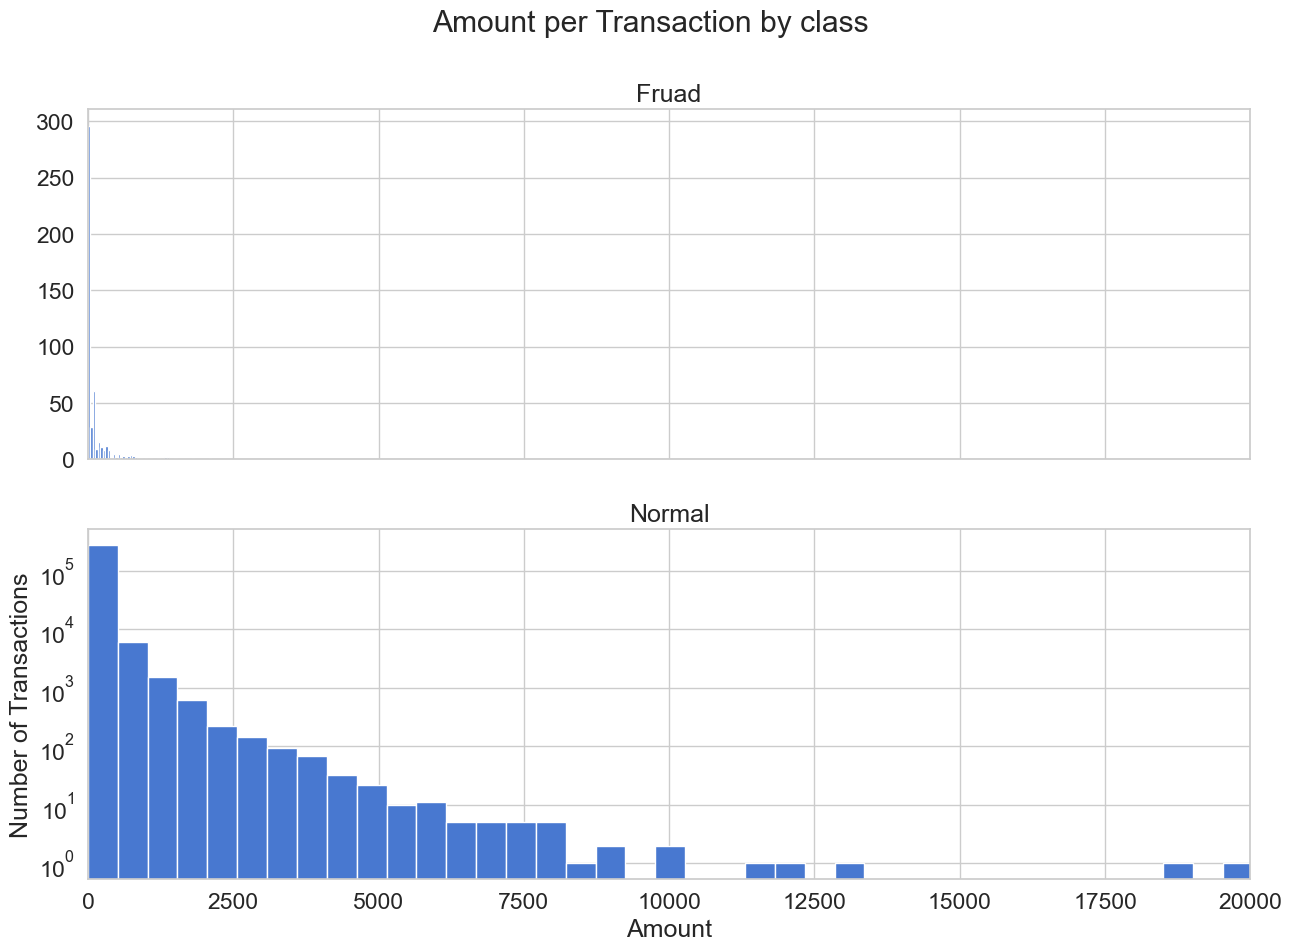

In [14]:
f, (ax1,ax2) = plt.subplots(2,1, sharex = True)
f.suptitle('Amount per Transaction by class')

bins = 50

ax1.hist(frauds.Amount, bins = bins)
ax1.set_title('Fruad')

ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount')
plt.ylabel('Number of Transactions')
plt.xlim((0,20000))
plt.yscale('log')
plt.show()

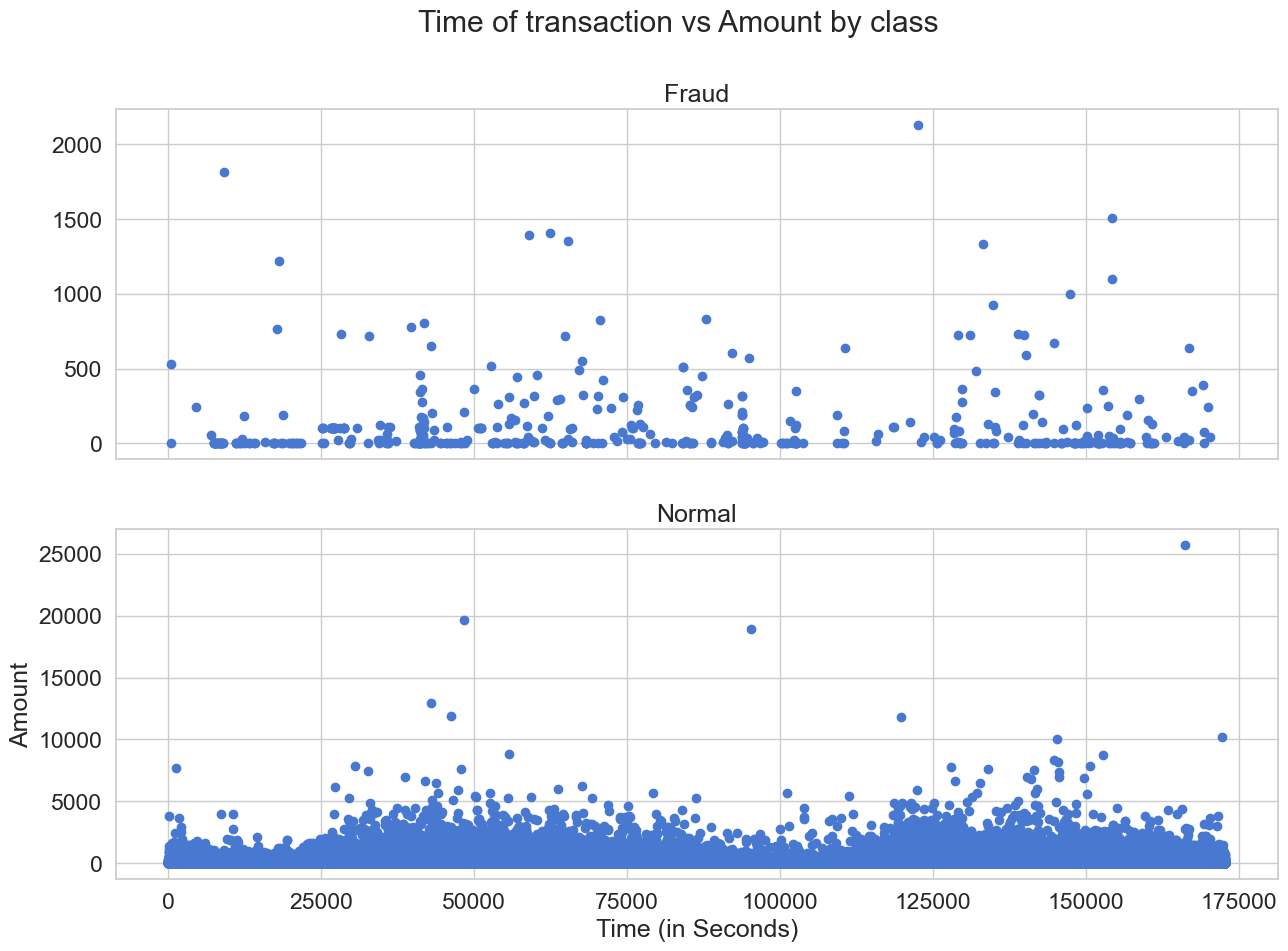

In [15]:
f, (ax1,ax2) = plt.subplots(2,1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')

ax1.scatter(frauds.Time, frauds.Amount)
ax1.set_title('Fraud')

ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

# Autoencoders

Autoencoders can seem quite bizarre at first. The job of those models is to predict the input, given that same input. Puzzling? Definitely was for me, the first time I heard it.

More specifically, let’s take a look at Autoencoder Neural Networks. This autoencoder tries to learn to approximate the following identity function:

While trying to do just that might sound trivial at first, it is important to note that we want to learn a compressed representation of the data, thus find structure. This can be done by limiting the number of hidden units in the model. Those kind of autoencoders are called undercomplete.

Here's a visual representation of what an Autoencoder might learn:

# Reconstruction error

We optimize the parameters of our Autoencoder model in such way that a special kind of error - reconstruction error is minimized. In practice, the traditional squared error is often used

If you want to learn more about Autoencoders I highly recommend the following videos by Hugo Larochelle:

# Preparing the data

First, let's drop the Time column (not going to use it) and use the scikit's StandardScaler on the Amount. The scaler removes the mean and scales the values to unit variance:

In [16]:
from sklearn.preprocessing import StandardScaler

data = df.drop(['Time'], axis=1)

data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1,1))

Training our Autoencoder is gonna be a bit different from what we are used to. Let's say you have a dataset containing a lot of non fraudulent transactions at hand. You want to detect any anomaly on new transactions. We will create this situation by training our model on the normal transactions, only. Reserving the correct class on the test set will give us a way to evaluate the performance of our model. We will reserve 20% of our data for testing:

In [17]:
X_train,X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.Class==0]
X_train = X_train.drop(['Class'],axis=1)

y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)

X_train = X_train.values
X_test = X_test.values

In [18]:
X_train.shape

(227451, 29)

# Building the model

Our Autoencoder uses 4 fully connected layers with 14, 7, 7 and 29 neurons respectively. The first two layers are used for our encoder, the last two go for the decoder. Additionally, L1 regularization will be used during training:

In [19]:
input_dim = X_train.shape[1]
encoding_dim = 14

In [20]:
input_layer = Input(shape=(input_dim,))

encoder = Dense(encoding_dim, activation="tanh",activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim/2), activation="relu")(encoder)

decoder = Dense(int(encoding_dim/2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs = input_layer, outputs = decoder)

Let's train our model for 100 epochs with a batch size of 32 samples and save the best performing model to a file. The ModelCheckpoint provided by Keras is really handy for such tasks. Additionally, the training progress will be exported in a format that TensorBoard understands.

In [21]:
nb_epoch = 100
batch_size = 32

autoencoder.compile(optimizer='adam',loss='mean_squared_error',metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="E:/Data Science/Credit Card Fraud Detection/model.h5",verbose=0,save_best_only=True)
tensorboard = TensorBoard(log_dir="E:/Data Science/Credit Card Fraud Detection/logs",histogram_freq=0,write_graph=True,write_images=True)
history = autoencoder.fit(X_train,X_train,epochs=nb_epoch,batch_size=batch_size,shuffle=True,validation_data=(X_test,X_test),verbose=1,callbacks=[checkpointer,tensorboard]).history


Epoch 1/100

7091/7108 [============================>.] - ETA: 0s - loss: 0.8055 - accuracy: 0.5867

C:\Users\harsh\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7108/7108 [==============================] - 22s 3ms/step - loss: 0.8052 - accuracy: 0.5868 - val_loss: 0.7824 - val_accuracy: 0.6485
Epoch 2/100
7108/7108 [==============================] - 18s 3ms/step - loss: 0.7418 - accuracy: 0.6641 - val_loss: 0.7661 - val_accuracy: 0.6688
Epoch 3/100
7108/7108 [==============================] - 17s 2ms/step - loss: 0.7325 - accuracy: 0.6764 - val_loss: 0.7609 - val_accuracy: 0.6782
Epoch 4/100
7108/7108 [==============================] - 14s 2ms/step - loss: 0.7280 - accuracy: 0.6761 - val_loss: 0.7572 - val_accuracy: 0.6753
Epoch 5/100
7108/7108 [==============================] - 15s 2ms/step - loss: 0.7214 - accuracy: 0.6742 - val_loss: 0.7503 - val_accuracy: 0.6872
Epoch 6/100
7108/7108 [==============================] - 16s 2ms/step - loss: 0.7169 - accuracy: 0.6929 - val_loss: 0.7476 - val_accuracy: 0.7018
Epoch 7/100
7108/7108 [==============================] - 15s 2ms/step - loss: 0.7135 - accuracy: 0.7047 - val_loss: 0.7451 - val_accurac

Epoch 57/100
7108/7108 [==============================] - 14s 2ms/step - loss: 0.6908 - accuracy: 0.7156 - val_loss: 0.7276 - val_accuracy: 0.7156
Epoch 58/100
7108/7108 [==============================] - 14s 2ms/step - loss: 0.6910 - accuracy: 0.7154 - val_loss: 0.7350 - val_accuracy: 0.6898
Epoch 59/100
7108/7108 [==============================] - 14s 2ms/step - loss: 0.6908 - accuracy: 0.7149 - val_loss: 0.7257 - val_accuracy: 0.7217
Epoch 60/100
7108/7108 [==============================] - 14s 2ms/step - loss: 0.6912 - accuracy: 0.7158 - val_loss: 0.7266 - val_accuracy: 0.7140
Epoch 61/100
7108/7108 [==============================] - 14s 2ms/step - loss: 0.6907 - accuracy: 0.7156 - val_loss: 0.7258 - val_accuracy: 0.7136
Epoch 62/100
7108/7108 [==============================] - 14s 2ms/step - loss: 0.6908 - accuracy: 0.7158 - val_loss: 0.7259 - val_accuracy: 0.7216
Epoch 63/100
7108/7108 [==============================] - 16s 2ms/step - loss: 0.6909 - accuracy: 0.7156 - val_loss: 0

# Model Summary

In [22]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 29)]              0         
                                                                 
 dense (Dense)               (None, 14)                420       
                                                                 
 dense_1 (Dense)             (None, 7)                 105       
                                                                 
 dense_2 (Dense)             (None, 7)                 56        
                                                                 
 dense_3 (Dense)             (None, 29)                232       
                                                                 
Total params: 813 (3.18 KB)
Trainable params: 813 (3.18 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [23]:
autoencoder = load_model("E:/Data Science/Credit Card Fraud Detection/model.h5")

# Evaluation

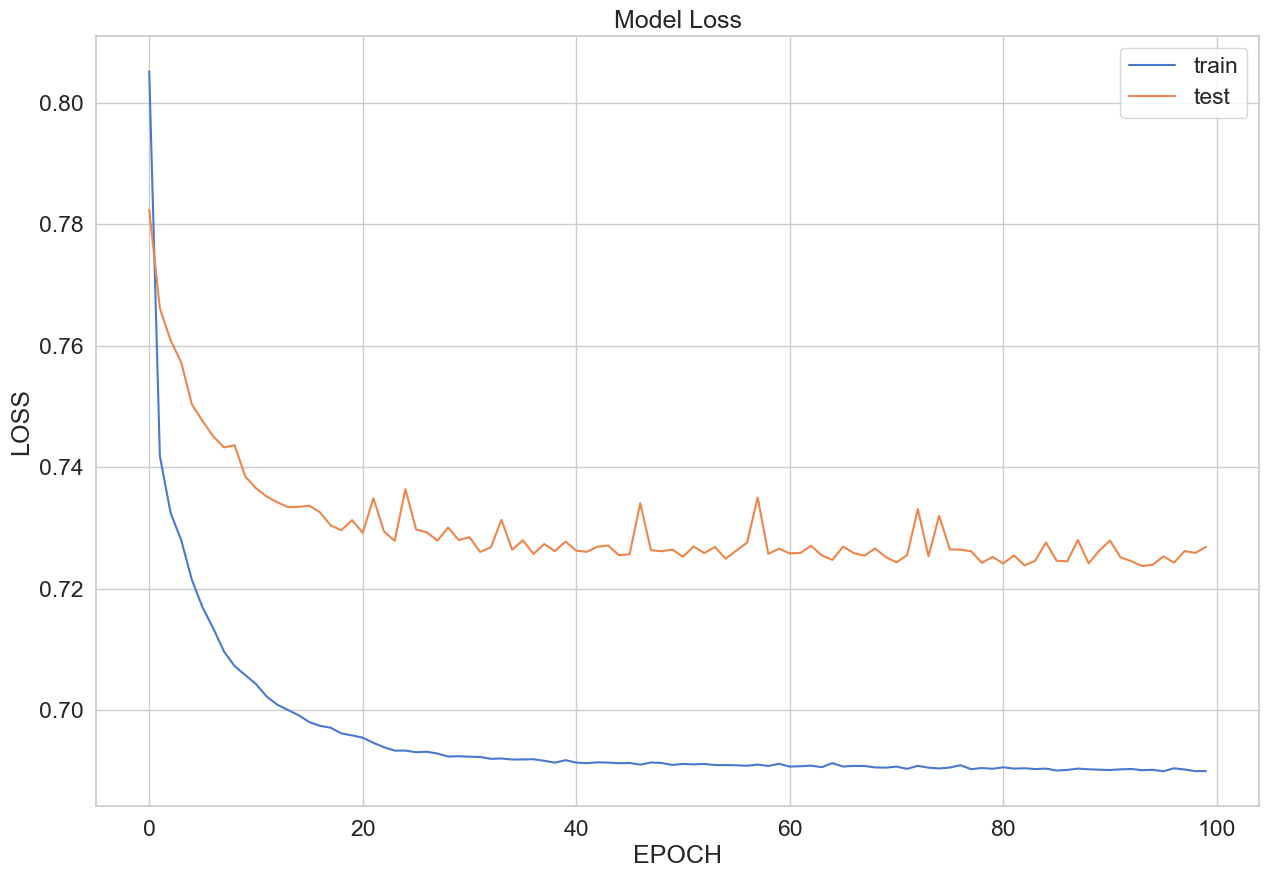

In [24]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title("Model Loss")
plt.ylabel("LOSS")
plt.xlabel("EPOCH")
plt.legend(['train','test'], loc='upper right')

In [25]:
predictions = autoencoder.predict(X_test)

1781/1781 [==============================] - 3s 959us/step


In [26]:
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,'true_class':y_test})

In [27]:
error_df.describe()

,reconstruction_error,true_class
count,56962.000000,56962.000000
mean,0.722771,0.001720
std,3.400046,0.041443
min,0.043527,0.000000
25%,0.233661,0.000000
50%,0.387792,0.000000
75%,0.610609,0.000000
max,258.763951,1.000000


# Reconstruction error without fraud

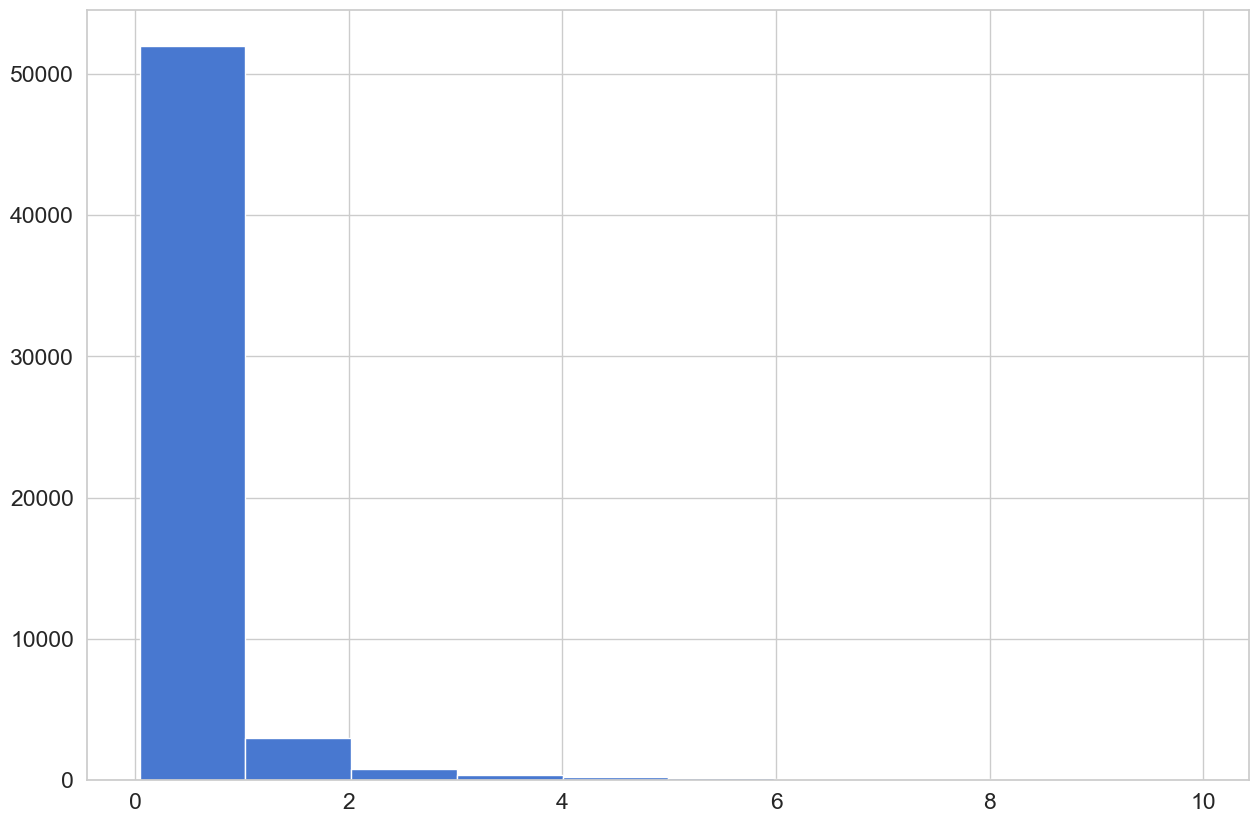

In [29]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']==0) & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)

# Reconstruction error with fraud

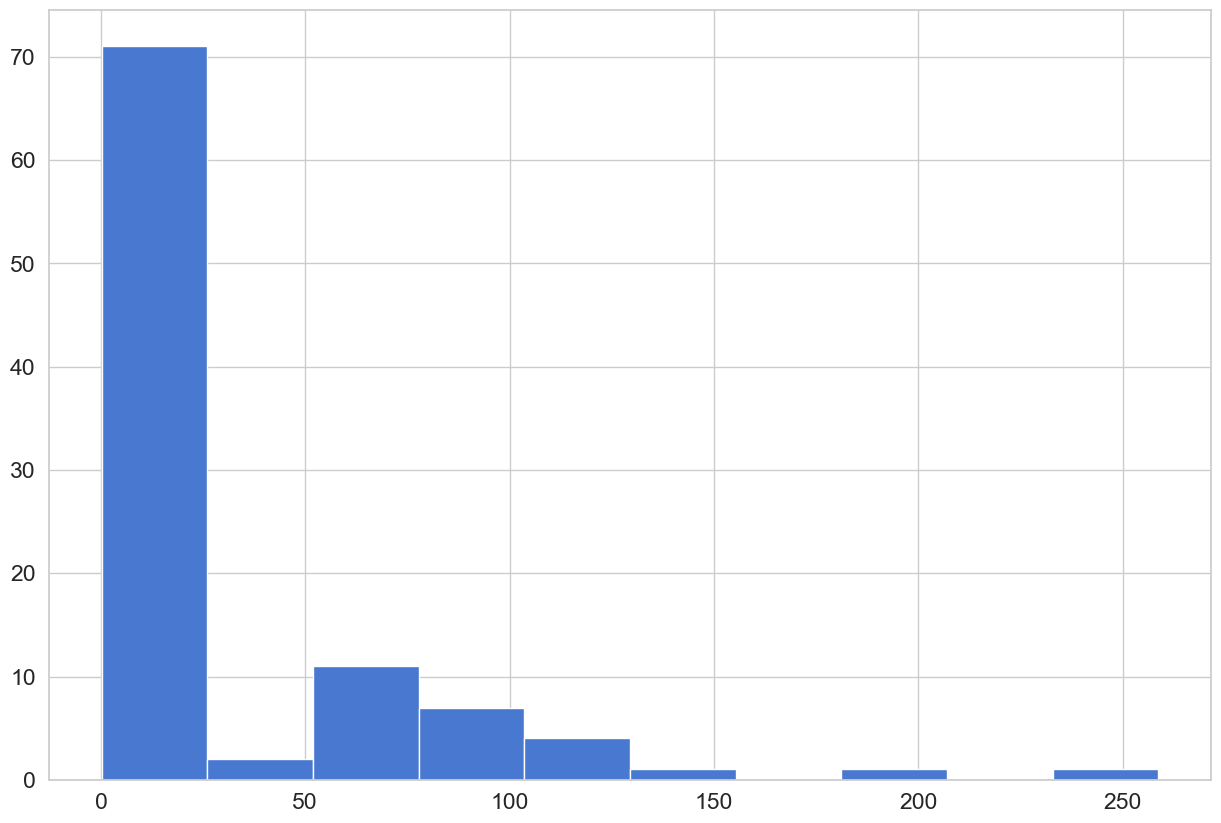

In [30]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class']==1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)

In [34]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,roc_curve, recall_score, classification_report, f1_score,precision_recall_fscore_support)

ROC curves are very useful tool for understanding the performance of binary classifiers. However, our case is a bit out of the ordinary. We have a very imbalanced dataset. Nonetheless, let's have a look at our ROC curve:

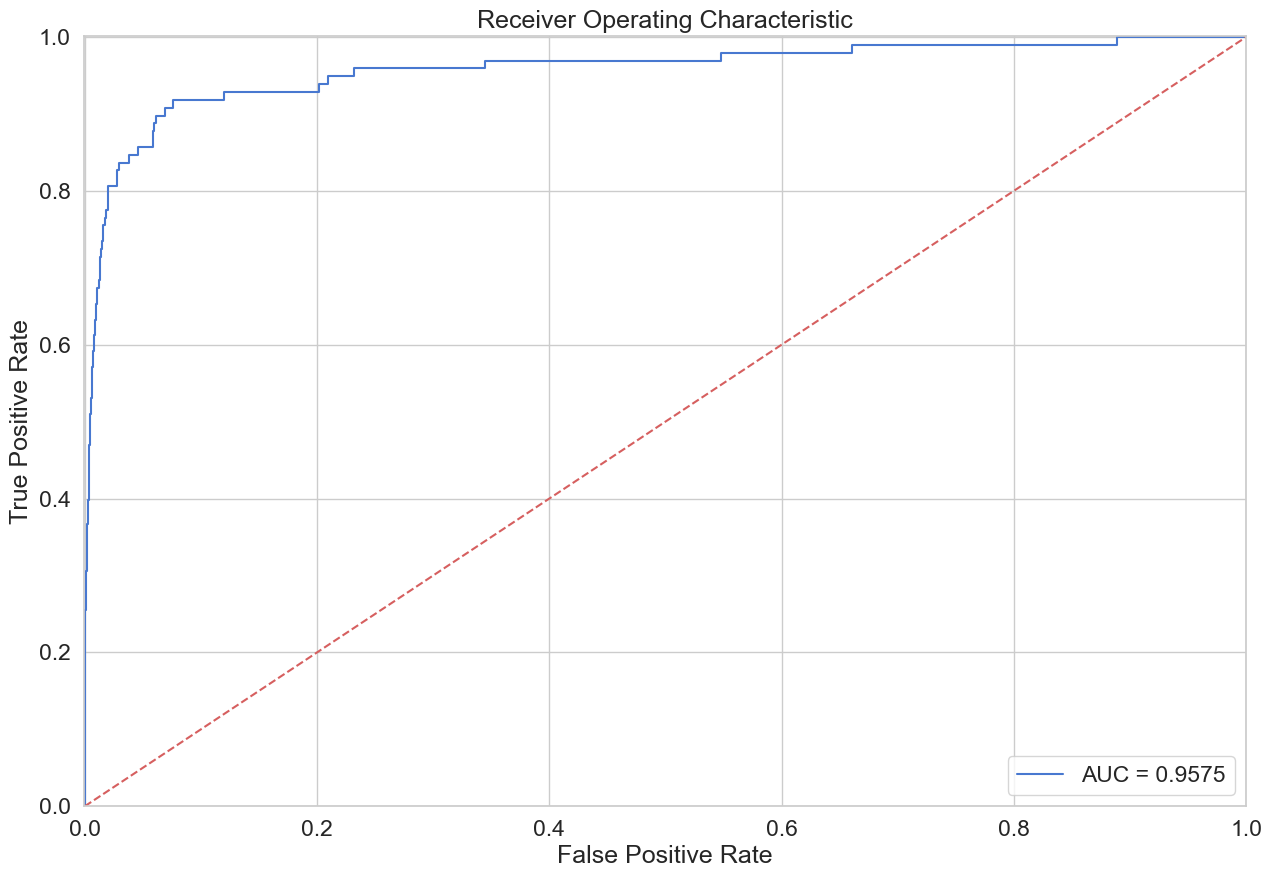

In [35]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr,tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001,1])
plt.ylim([0,1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

The ROC curve plots the true positive rate versus the false positive rate, over different threshold values. Basically, we want the blue line to be as close as possible to the upper left corner. While our results look pretty good, we have to keep in mind of the nature of our dataset. ROC doesn't look very useful for us. Onward...
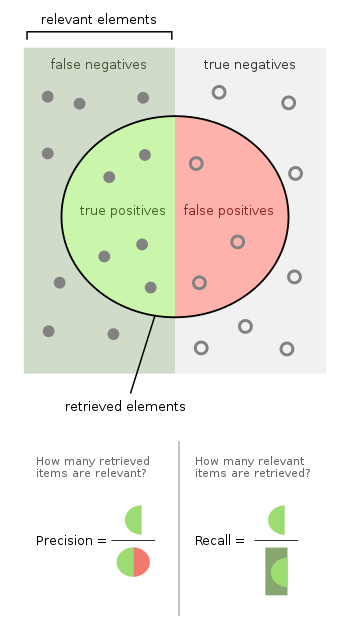
Let's take an example from Information Retrieval in order to better understand what precision and recall are. Precision measures the relevancy of obtained results. Recall, on the other hand, measures how many relevant results are returned. Both values can take values between 0 and 1. You would love to have a system with both values being equal to 1.

Let's return to our example from Information Retrieval. High recall but low precision means many results, most of which has low or no relevancy. When precision is high but recall is low we have the opposite - few returned results with very high relevancy. Ideally, you would want high precision and high recall - many results with that are highly relevant.

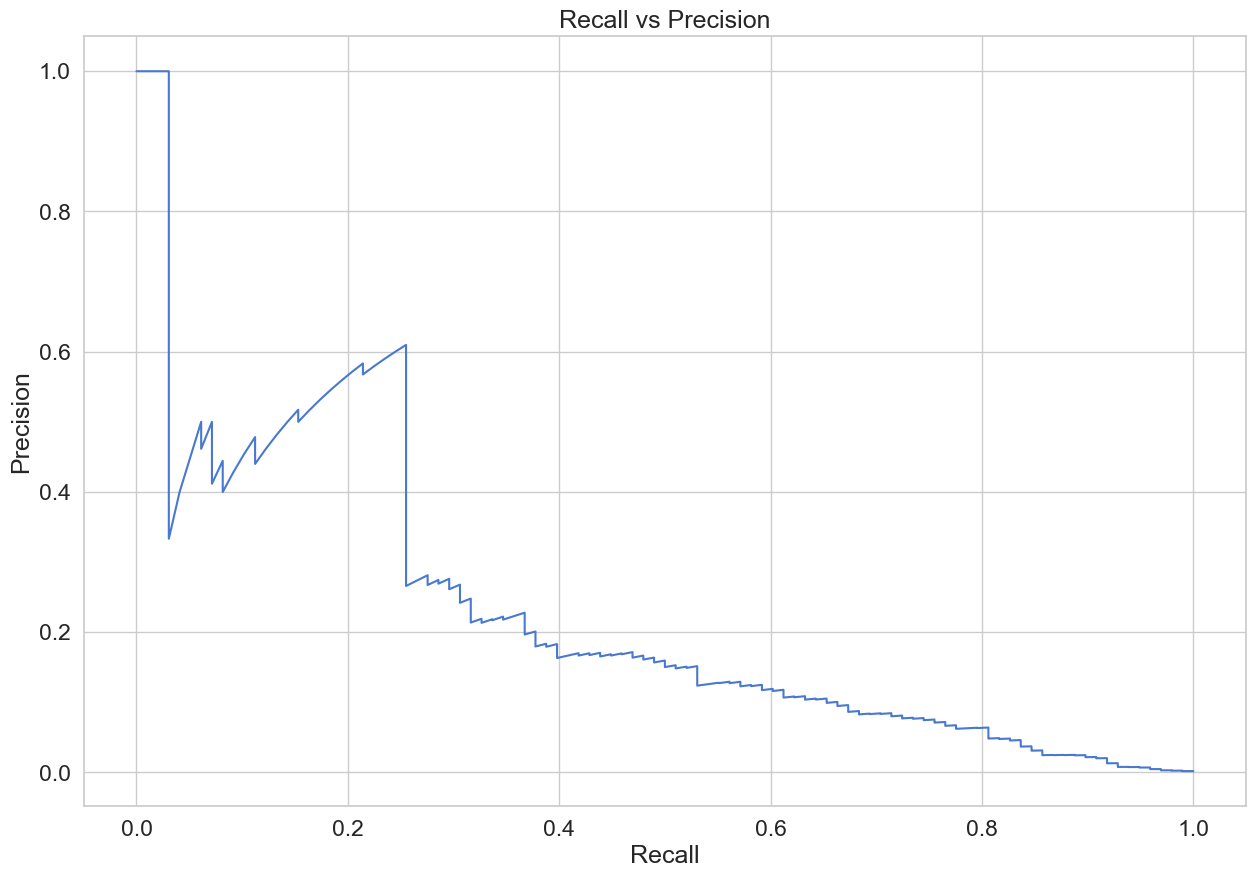

In [36]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall,precision,'b',label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate. High scores for both show that the classifier is returning accurate results (high precision), as well as returning a majority of all positive results (high recall).

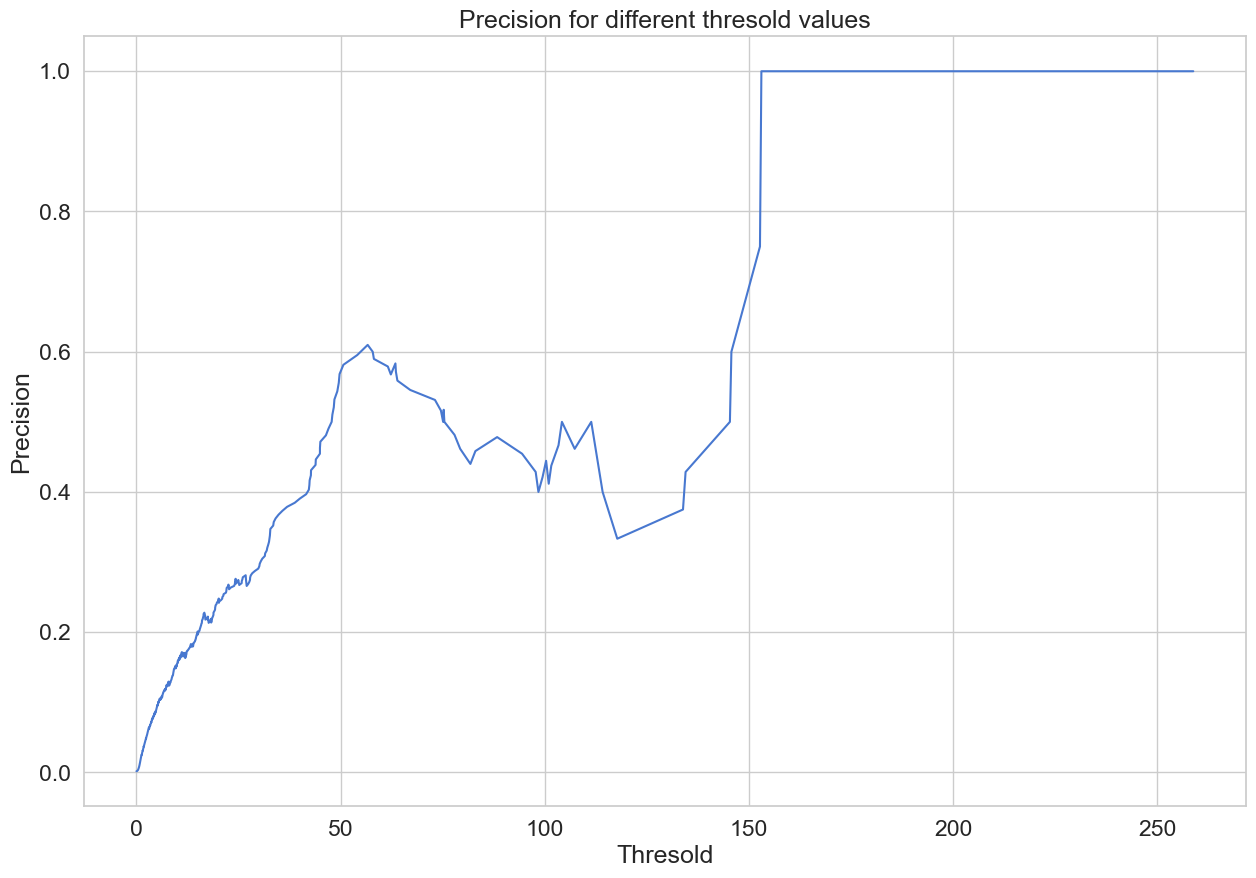

In [37]:
plt.plot(th,precision[1:],'b',label='Thresold-Precision curve')
plt.title('Precision for different thresold values')
plt.xlabel('Thresold')
plt.ylabel('Precision')
plt.show()

You can see that as the reconstruction error increases our precision rises as well. Let's have a look at the recall:

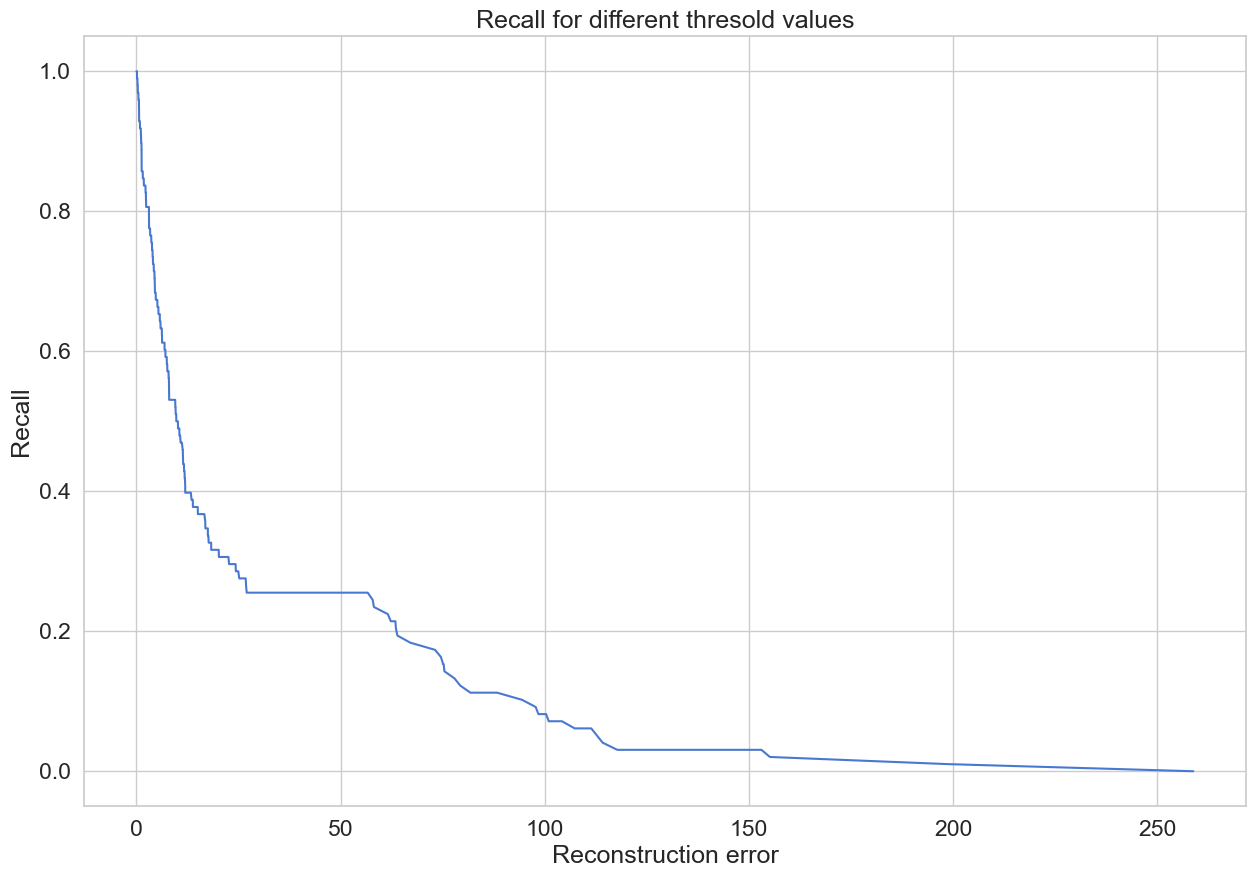

In [38]:
plt.plot(th,recall[1:],'b', label='Thresold-Recall curve')
plt.title('Recall for different thresold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

Here, we have the exact opposite situation. As the reconstruction error increases the recall decreases.

# Prediction

Our model is a bit different this time. It doesn't know how to predict new values. But we don't need that. In order to predict whether or not a new/unseen transaction is normal or fraudulent, we'll calculate the reconstruction error from the transaction data itself. If the error is larger than a predefined threshold, we'll mark it as a fraud (since our model should have a low error on normal transactions). Let's pick that value:

In [39]:
thresold = 2.9

And see how well we're dividing the two types of transactions:

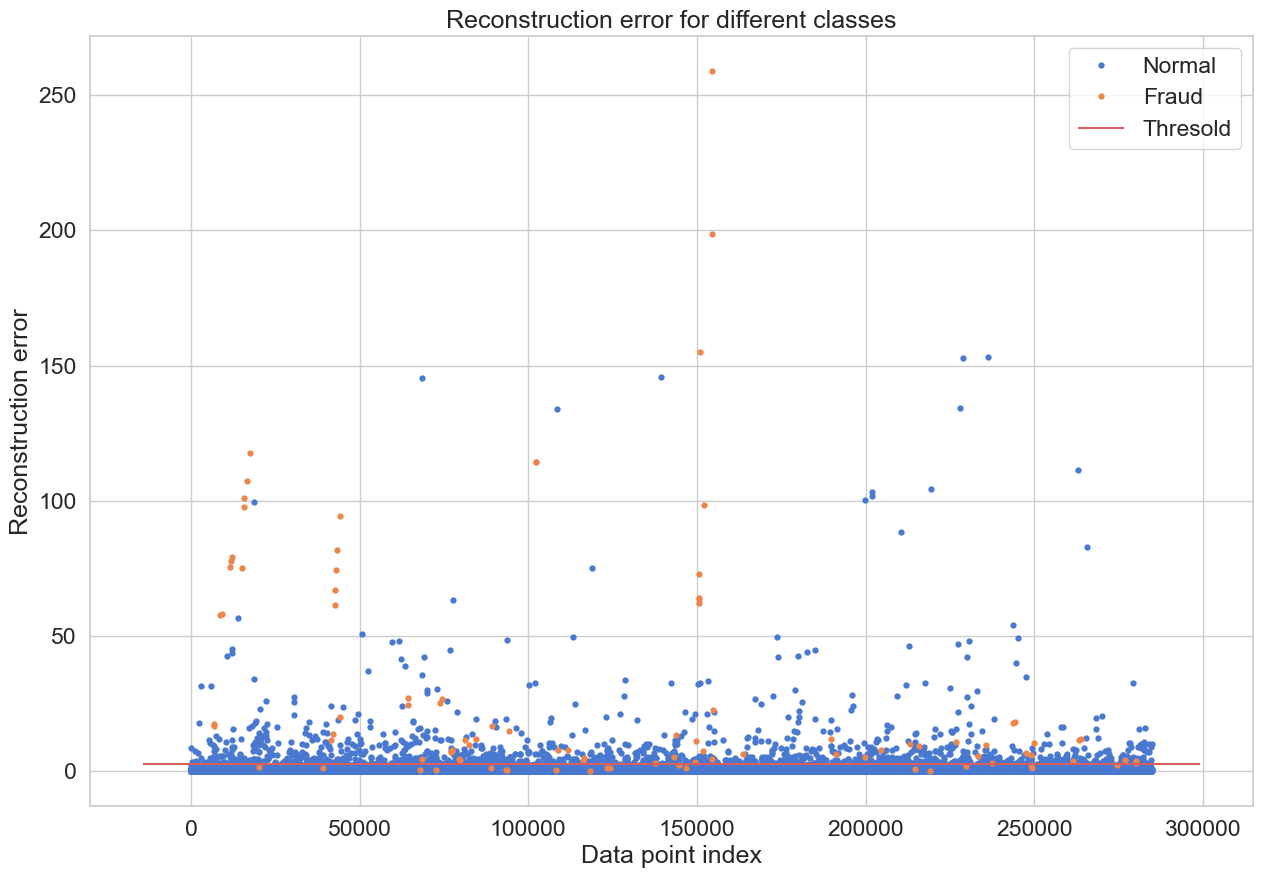

In [40]:
groups = error_df.groupby('true_class')
fig,ax = plt.subplots()

for name,group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',label='Fraud' if name == 1 else "Normal")

ax.hlines(thresold, ax.get_xlim()[0], ax.get_xlim()[1], colors='r', zorder=100, label='Thresold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

I know, that chart might be a bit deceiving. Let's have a look at the confusion matrix:

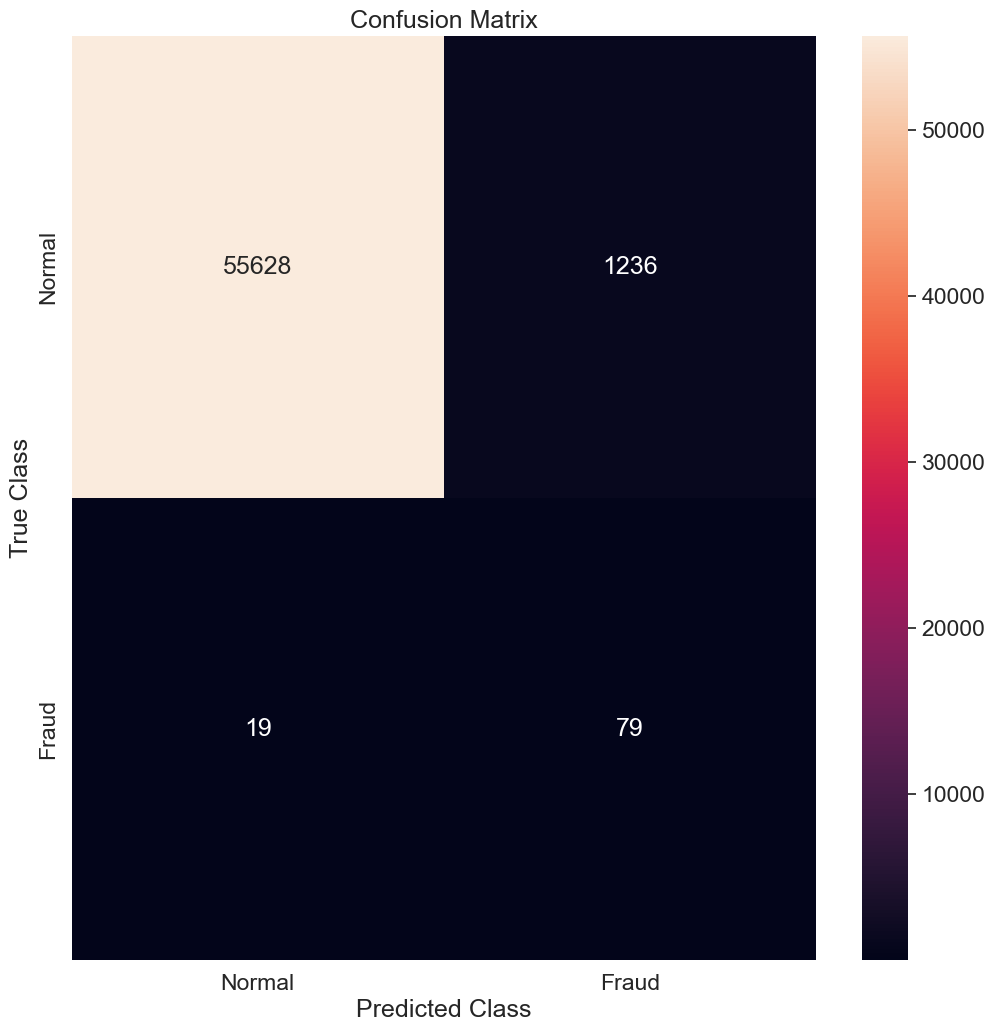

In [41]:
y_pred = [1 if e > thresold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(12,12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.ylabel("True Class")
plt.xlabel("Predicted Class")
plt.show()

Our model seems to catch a lot of the fraudulent cases. Of course, there is a catch (see what I did there?). The number of normal transactions classified as frauds is really high. Is this really a problem? Probably it is. You might want to increase or decrease the value of the threshold, depending on the problem. That one is up to you.

# Conclusion

We've created a very simple Deep Autoencoder in Keras that can reconstruct what non fraudulent transactions looks like. Initially, I was a bit skeptical about whether or not this whole thing is gonna work out, bit it kinda did. Think about it, we gave a lot of one-class examples (normal transactions) to a model and it learned (somewhat) how to discriminate whether or not new examples belong to that same class. Isn't that cool? Our dataset was kind of magical, though. We really don't know what the original features look like.

Keras gave us very clean and easy to use API to build a non-trivial Deep Autoencoder. You can search for TensorFlow implementations and see for yourself how much boilerplate you need in order to train one.

# References

https://blog.keras.io/building-autoencoders-in-keras.html
http://ufldl.stanford.edu/tutorial/unsupervised/Autoencoders
http://cmgreen.io/2016/01/04/tensorflow_deep_autoencoder.html